In [0]:
import os

if 'pokemon-sprites.tar.gz' not in os.listdir():
  !wget https://s3.amazonaws.com/syaffers-stuff/datasets/pokemon-sprites.tar.gz

if 'pokemon-sprites' not in os.listdir():
  !tar xzvf pokemon-sprites.tar.gz

Streaming output truncated to the last 5000 lines.
pokemon-sprites/renamed/K5E3REMLP5G3TKINTK3TROGYGY.png
pokemon-sprites/renamed/CP3JYSJSCFANND6SAT7RACDC5Y.png
pokemon-sprites/renamed/LU6JRPNJUVE6XBQDVURLAX42FA.png
pokemon-sprites/renamed/EATVTOWOS5A63DZEZX3BL2I4UE.png
pokemon-sprites/renamed/GIYST5NXXVEPBJRPLT2NF4RUG4.png
pokemon-sprites/renamed/HY5QAOKLEVC7BA32IGD6T7BKGM.png
pokemon-sprites/renamed/LDQQRAWXJ5H3LILWX2NXRHIYVE.png
pokemon-sprites/renamed/KQKGC2QKAFGNVIGRP6SULI7SVI.png
pokemon-sprites/renamed/M4UG2UBR2JE3VIIBOSZLRGB32A.png
pokemon-sprites/renamed/BVZG7T6KKVEW5MGI6F3G5LZJAI.png
pokemon-sprites/renamed/FF2QJBHSLFB55HDCEKA6YJB5II.png
pokemon-sprites/renamed/7SH2O2ZCFBFVLHABC4XJJEGNIY.png
pokemon-sprites/renamed/KE44PW44OVE3DG24FBY4VQ47YQ.png
pokemon-sprites/renamed/EBUY4YHE6NGNJI3LO7VXTEGGCA.png
pokemon-sprites/renamed/EKKR3M7JERGAXOWUKBXCAZM37Q.png
pokemon-sprites/renamed/YYWZKI6QNRH3NC3UPWXRYASSS4.png
pokemon-sprites/renamed/JZH4BEQCHRGDBCO65YOZPDLQ7M.png
pokemon-sprite

In [0]:
import tensorflow as tf
import time
from glob import glob
from IPython.display import Image, clear_output
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
from PIL import Image
from tensorflow.keras import layers

In [0]:
images = glob("pokemon-sprites/renamed/*")
image_count = len(list(images))
image_count

15555

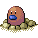

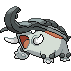

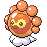

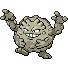

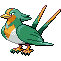

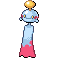

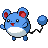

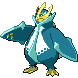

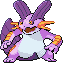

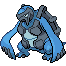

In [0]:
for image_path in images[:10]:
    display.display(Image.open(str(image_path)))

In [0]:
nf = 64
BUFFER_SIZE = 60000
batch_size = 32

def parse_function(filename):
    image_string = tf.io.read_file(filename)
    # Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_png(image_string, channels=3)
    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [nf, nf], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image

dataset = tf.data.Dataset.from_tensor_slices((images,))
dataset = dataset.shuffle(len(images))
dataset = dataset.map(parse_function, num_parallel_calls=4)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(1)

In [0]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(200,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

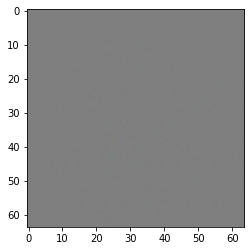

In [0]:
generator = make_generator_model()

noise = tf.random.normal([1, 200])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :])

In [0]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [0]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.01050347]], shape=(1, 1), dtype=float32)


In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
EPOCHS = 1000
noise_dim = 200
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 50 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((predictions[i, :, :, :] * 127.5 + 127.5) / 255.)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

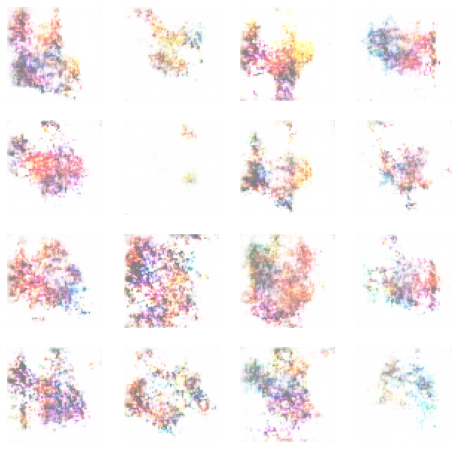

Time for epoch 131 is 13.647344589233398 sec


In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

train(dataset, EPOCHS)

In [0]:
import PIL
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [0]:
display_image(91)

In [0]:
import imageio
import glob

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

In [0]:
!zip -r /content/checkpoints.zip /content/training_checkpoints

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download("/content/checkpoints.zip")